In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pystarboard.data_spacescope as dss
from datetime import date, timedelta

In [3]:
EXBI = 2**60
EIB = EXBI  # a convenience alias
EXA = 10**18
PIB = 2**50
GIB = 2**30
SECTOR_SIZE = 32 * GIB

PIB_PER_SECTOR = SECTOR_SIZE / PIB
EIB_PER_SECTOR = SECTOR_SIZE / EIB

In [17]:
import os
token = os.path.join('/Users/kiran/code/cel/auth/spacescope_auth.json')
ss = dss.SpacescopeDataConnection(token)

In [18]:
start_date = date(2023, 1, 1)
end_date = date(2025, 3 ,1)

In [19]:
econ_df = ss.get_sector_economics_stats(start_date, end_date)

In [7]:
supply_df = ss.query_spacescope_supply_stats(start_date, end_date)

In [8]:
url_template = "https://api.spacescope.io/v2/gas/daily_network_fee_breakdown?end_date=%s&start_date=%s"
fee_df = ss.spacescope_query(start_date, end_date, url_template)

In [9]:
url_template = "https://api.spacescope.io/v2/economics/block_reward?end_date=%s&start_date=%s"
br_df = ss.spacescope_query(start_date, end_date, url_template)

In [10]:
network_df = ss.get_historical_network_stats(start_date, end_date, end_date)

In [11]:
total_onboarded_day_pib = network_df['day_onboarded_qa_power_pib'] + network_df['day_renewed_qa_power_pib']
SECTORS_PER_PIB = 1/PIB_PER_SECTOR
total_onboarded_day_sectors = total_onboarded_day_pib * SECTORS_PER_PIB

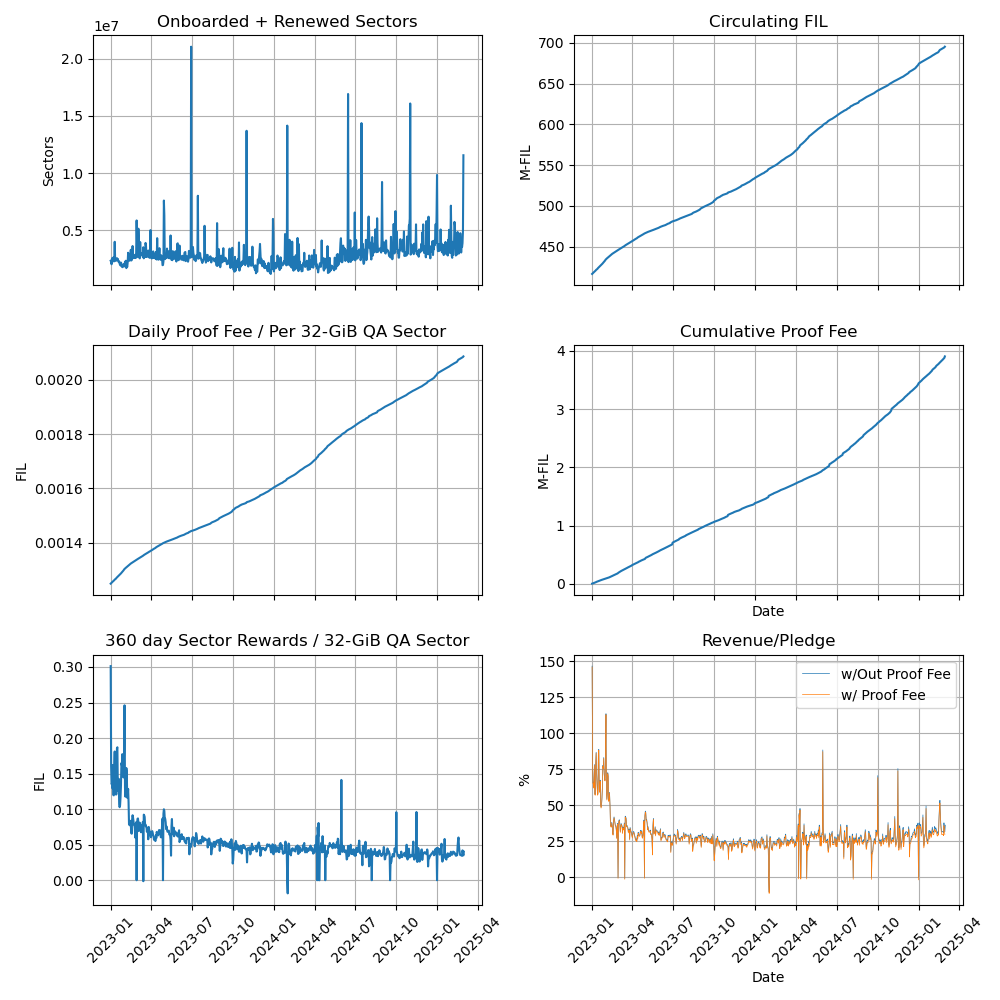

In [13]:
K = 3e-12
per_sector_fee = network_df['circulating_fil'] * K
day_proof_fee = per_sector_fee * total_onboarded_day_sectors
cum_proof_fee = day_proof_fee.cumsum()
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(10, 10), sharex=True)

axx = ax[0, 0]
axx.plot(network_df['date'], total_onboarded_day_sectors)
axx.set_ylabel('Sectors')
axx.set_title('Onboarded + Renewed Sectors')
axx.grid(True)

axx = ax[0, 1]
axx.plot(network_df['date'], network_df['circulating_fil']/1e6)
axx.set_ylabel('M-FIL')
axx.set_title('Circulating FIL')
axx.grid(True)

axx = ax[1, 0]
axx.plot(network_df['date'], network_df['circulating_fil'] * K)
axx.set_ylabel('FIL')
axx.set_title('Daily Proof Fee / Per 32-GiB QA Sector')
axx.grid(True)

axx = ax[1,1]
axx.plot(network_df['date'], cum_proof_fee/1e6)
axx.set_xlabel('Date')
axx.set_title('Cumulative Proof Fee')
axx.set_ylabel('M-FIL')
axx.grid(True)

x = (econ_df['sector_rewards_360d_32gib']) /econ_df['sector_initial_pledge_32gib']
y = (econ_df['sector_rewards_360d_32gib'] - per_sector_fee) /econ_df['sector_initial_pledge_32gib']

axx = ax[2, 0]
axx.plot(econ_df['date'], econ_df['sector_rewards_360d_32gib'])
axx.set_ylabel('FIL')
axx.set_title('360 day Sector Rewards / 32-GiB QA Sector')
for tick in axx.get_xticklabels():
    tick.set_rotation(45)
axx.grid(True)

axx = ax[2, 1]
axx.plot(econ_df['date'], x*100, label='w/Out Proof Fee', linewidth=0.5)
axx.plot(econ_df['date'], y*100, label='w/ Proof Fee', linewidth=0.5)
axx.set_ylabel('%')
axx.set_xlabel('Date')
axx.legend()
for tick in axx.get_xticklabels():
    tick.set_rotation(45)
axx.set_title('Revenue/Pledge')
axx.grid(True)

plt.tight_layout()
plt.savefig('historical_proof_fees.png')